## 5章：パーティクルフィルタによる自己位置推定(後半)


- ここまでで、ロボットの姿勢のバラつきを実装してきた
- ただ、これだとただパーティクルが拡散するだけでロボットの姿 勢はだんだんと分からなくなる
- よって、センサの情報からこれを補正する必要がある

### センサ値によるパーティクルの姿勢の評価
- まずは単純な例
  - あるセンサ値が得られたときに、二つのパーティクルのどっちが真値にふさわしいか？
    - 当然、ロボットに近い方がふさわしい
  - これは観測モデルの比で表せる
    - 例：$p_j(z_j|x^{(i)})=0.02,p_j(z_j|x^{(k)})=0.01$とする
    - $x^(i)$の方が$x^(k)$より2倍尤もらしいといえる
      - この値は確率ではないが、比較は可能
      - 比：尤度比、数値：尤度
      - $p_j(z_j|x^{(i)})$は自明ではないので、後ほど実験から求める

**尤度関数**
  - $p_j(z_j|x^{(i)})$について、本来zを取得してxを変数とするはずが逆になっている
    - xを変数とみなした尤度関数で表現
    - $L_j(x|z_j)=\eta _j(z_j|x)$
      - 比を使うだけなので、$\eta$は正であれば何でもよい

**ベイズの定理からの導出**
- $b_t(x_t^{(i)})=\hat{b_t}(x_t^{(i)}|z_{j,t})$
- $= \eta p_j(z_{j,t}|x_t^{i})\hat{b_t}(x_t^{(i)})$
  - 事前信念に対して、パーティクルの姿勢を決めた上でのセンサの値による確率密度を用いて信念の更新を行う
- $= \eta L_j(x_t^{i}|z_{j,t})\hat{b_t}(x_t^{(i)})$
  - 当然、パーティクルの姿勢とセンサ値の条件付確率についてひっくり返すこともできる
  - なおここの事前分布$\hat{b_t}(x_t^{(i)})$は1になる、これまで全てのパーティクルの主にを同じに考えていたため

**パーティクルの重み**
- 尤度は重みとしてパーティクルの分布に反映する
  - 今まではロボットの分身として$x_t-{(i)}$で考えていたが重み$w_t-{(i)}$も含めるとして再定義
- パーティクルの再定義
  - $\xi _t^{(i)}=(x_t-{(i)},w_t-{(i)})$
  - $\Sigma _{i=0}^{N-1} w^{(i)}=1$
    - 重みは足したら1
- 信念分布を次のように定義
  - $P(x_t^* \in X)=\int _{x \in X}b_t(x)dx \approx \sigma_{i=0}^{N-1}w_i^{(i)} \delta(x_t^{(j)} \in X)$
    - Xに真の姿勢が含まれる確率を、パーティクルの重み付き和で近似
- 重みの計算(後ほど正規化)
  - $w_t^{(i)}=L_j(x_t^{(i)}|z_{j,t})\hat w_t^{(i)}$
    - 重みは尤度関数でアップデートすればよい

In [1]:
# conect to drive on colab
# from google.colab import drive
# drive.mount("/content/drive")
# dir_path="./drive/MyDrive/Colab Notebooks/ProbabilisticRobotics/"
dir_path="./"

import sys
sys.path.append(dir_path)
from robot import *

import copy

from scipy.stats import expon,norm,uniform,multivariate_normal
import numpy as np
import pandas as pd
pi=np.pi

In [9]:
class EstimationAgent(Agent):
    def __init__(self,time_interval,nu,omega,estimator):
        super().__init__(nu,omega)
        self.estimator=estimator
        self.time_interval=time_interval

        self.prev_nu=0.0
        self.prev_omega=0.0
             
    def decision(self,observation=None):
        self.estimator.motion_update(self.prev_nu,self.prev_omega,self.time_interval)
        self.prev_nu,self.prev_omega=self.nu,self.omega
        self.estimator.observation_update(observation)
        return self.nu,self.omega
   
    def draw(self,ax,elems):
        self.estimator.draw(ax,elems)
   

In [12]:
class Particle:
    def __init__(self,init_pose,weight):
        self.pose=init_pose
        self.weight=weight
        
    def motion_update(self,nu,omega,time,noise_rate_pdf):
        ns=noise_rate_pdf.rvs()
        noised_nu=nu+ns[0]*np.sqrt(abs(nu)/time)+ns[1]*np.sqrt(abs(omega)/time)
        noised_omega=omega+ns[2]*np.sqrt(abs(nu)/time)+ns[3]*np.sqrt(abs(omega)/time)
        self.pose=IdealRobot.state_transition(noised_nu,noised_omega,time,self.pose)
    
    def observation_update(self,observation):
        print(observation)
    

In [10]:

class Mcl:
    def __init__(self,init_pose,num,motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}) -> None:
        self.particles=[Particle(init_pose,1/num) for i in range(num)]
        
        # 4次元のガウス分布のオブジェクトを作成
        # diagは対角行列の生成
        v=motion_noise_stds
        c=np.diag([v["nn"]**2,v["no"]**2,v["on"]**2,v["oo"]**2])
        self.motion_noise_rate_pdf=multivariate_normal(cov=c)
 
    def motion_update(self,nu,omega,time):
            for p in self.particles:
                p.motion_update(nu,omega,time,self.motion_noise_rate_pdf)
 
    def draw(self,ax,elems):
        xs=[p.pose[0] for p in self.particles]
        ys=[p.pose[1] for p in self.particles]
        vxs=[np.cos(p.pose[2]) for p in self.particles]
        vys=[np.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,color="blue",alpha=0.5))
    
    def observation_update(self,observation):
        for p in self.particles:
                p.observation_update(observation)
        
    

[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.21636476, 0.6723719 ]), 2)]
[(array([ 3.65544009, -0.99320125]), 1), (array([4.2

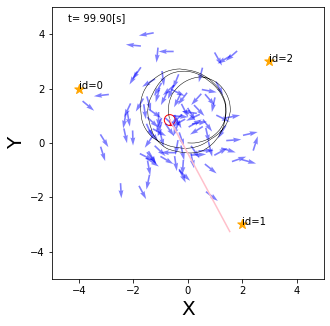

In [13]:
# パラメータ決めて描画テスト
# motion_noise_stds={"nn":1,"no":2,"on":3,"oo":4}
# motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2}
from distutils.log import debug


time_interval=0.1
world = World(30, time_interval)

m = Map()                                  
m.append_landmark(Landmark(-4,2))
m.append_landmark(Landmark(2,-3))
m.append_landmark(Landmark(3,3))
world.append(m)     

init_pose=np.array([0,0,0]).T
estimator=Mcl(init_pose,100)
circling=EstimationAgent(time_interval,0.2,10/180*pi,estimator)
r= Robot( init_pose, sensor=Camera(m), agent=circling,color="red")
world.append(r)

world.draw()

